# Chatbox for COVID-19 help etc. 

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPool1D, Flatten, Embedding, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Importing data

In [16]:
with open('./data/conversations.json') as f:
    data = json.load(f)

In [3]:
tags=[]
patternss=[]
responses={}
for intent in data['intents']:
    responses[intent['tag']]=intent['responses']
    for patterns in intent['patterns']:
        patternss.append(patterns)
        tags.append(intent['tag'])
    

In [4]:
data = pd.DataFrame({'patterns':patternss, 'tag':tags})

In [5]:
data

,patterns,tag
0,Can my friends visit me?,quarantine_visits
1,Can someone come see me during quarantine?,quarantine_visits
2,Is anyone allowed to visit during quarantine?,quarantine_visits
3,What is a safe distance when someone brings me...,quarantine_visits
4,Are quarantined visits allowed?,quarantine_visits
...,...,...
728,report of lung,lungs
729,lungs report,lungs
730,please check my lungs,lungs
731,can you check my lung report,lungs


In [6]:
# randomly shuffle the data
data = data.sample(frac=1)
data

,patterns,tag
411,where I can get tested,testing_locations
668,Can I get corona virus from my pet?,covid_pets_animals
56,Should I see a doctor if I am showing the symp...,go_hospital_see_doctor
420,how many cases are there in Texas?,case_count
522,what are my symptoms,symptoms
...,...,...
595,How contagious is COVID-19?,aboutvirus_transmission
288,Do I need to wear a face mask?,protecting_against_infection
703,Should I wear a mask or a respirator?,masks_protection
229,Whats the difference between cleaning and disi...,cleaning_disinfecting


# Pre-processing

In [7]:
#remove punctuation and convert to lower case
import string
data['patterns'] = data['patterns'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['patterns'] = data['patterns'].apply(lambda x: x.lower())
data

,patterns,tag
411,where i can get tested,testing_locations
668,can i get corona virus from my pet,covid_pets_animals
56,should i see a doctor if i am showing the symp...,go_hospital_see_doctor
420,how many cases are there in texas,case_count
522,what are my symptoms,symptoms
...,...,...
595,how contagious is covid19,aboutvirus_transmission
288,do i need to wear a face mask,protecting_against_infection
703,should i wear a mask or a respirator,masks_protection
229,whats the difference between cleaning and disi...,cleaning_disinfecting


In [8]:
# tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
x_train = tokenizer.texts_to_sequences(data['patterns'])

# add padding to the data
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encode the tags
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['tag'])
y_train = encoder.fit_transform(data['tag'])


In [9]:
input_shape1 = x_train.shape[1]
input_shape1

23

In [10]:
vocab_size = len(tokenizer.word_index)
vocab_size

647

In [11]:
output_size = encoder.classes_.shape[0]
output_size

45

# Neural Network

In [12]:
i = Input(shape=(input_shape1,))
x = Embedding(vocab_size+1, 10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_size, activation='softmax')(x)
model = Model(i, x)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# train the model
# train = model.fit(x_train, y_train, epochs=200, batch_size=64)
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
23/23 [==============================] - 1s 4ms/step - loss: 3.7818 - accuracy: 0.0573
Epoch 2/200
23/23 [==============================] - 0s 5ms/step - loss: 3.5975 - accuracy: 0.1037
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4902 - accuracy: 0.1037
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4784 - accuracy: 0.1105
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4639 - accuracy: 0.1037
Epoch 6/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4505 - accuracy: 0.1037
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4312 - accuracy: 0.1528
Epoch 8/200
23/23 [==============================] - 0s 4ms/step - loss: 3.3856 - accuracy: 0.1460
Epoch 9/200
23/23 [==============================] - 0s 4ms/step - loss: 3.3177 - accuracy: 0.1760
Epoch 10/200
23/23 [==============================] - 0s 4ms/step - loss: 3.2338 - accuracy: 0.1733
Epoch 11/

In [14]:
#save the model
model.save('../Models/chatbox_model.h5')

In [15]:
import pickle
# save the tokenizer, label encoder , response dictionary and input_shape in a single file in the form of a dictionary
pickle.dump({'encoder': encoder, 'tokenizer': tokenizer, 'responses': responses, 'input_shape': input_shape1}, open('chatbox_model.pkl', 'wb'))


# Model Analysis

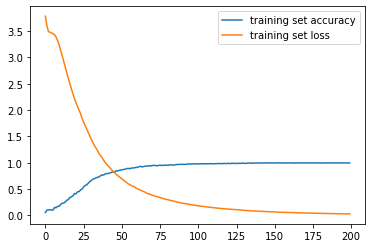

In [16]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

# Testing

In [17]:
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape1)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = encoder.inverse_transform([output])[0]
  final_output = random.choice(responses[response_tag])
  print("Covid 19- Chat bot : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

Covid 19- Chat bot :  Checking!
Covid 19- Chat bot :  Checking!
Covid 19- Chat bot :  Hey
Covid 19- Chat bot :  Hi
Covid 19- Chat bot :  Checking!
Covid 19- Chat bot :  What's up
Covid 19- Chat bot :  What's up
Covid 19- Chat bot :  Have a nice day
